In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35

data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
print(data)

[1 0 0 0]


### Model Specifications
$$ \theta \sim Beta(\alpha, \beta) $$
$$ y \sim Bin(n=1, p = \theta) $$

In [3]:
import pymc3 as pm

In [4]:
with pm.Model() as first_model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

logp = -2.7726, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 70.88it/s]
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 8745.71draws/s]
The number of effective samples is smaller than 25% for some parameters.


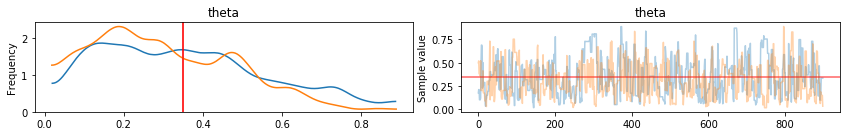

In [5]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta': theta_real});

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 7703.67draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f074821bc88>,
      dtype=object)

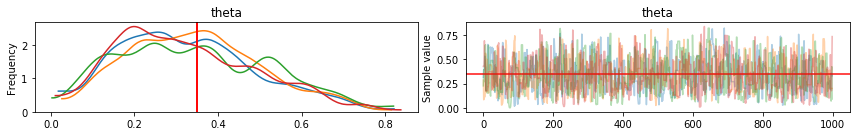

In [13]:
with first_model:
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step, njobs=4)

burnin = 0
multi_chain = multi_trace[burnin:]
pm.traceplot(multi_trace, lines = {'theta' : theta_real})

In [14]:
pm.gelman_rubin(multi_chain)

{'theta': 1.0018626553859296}

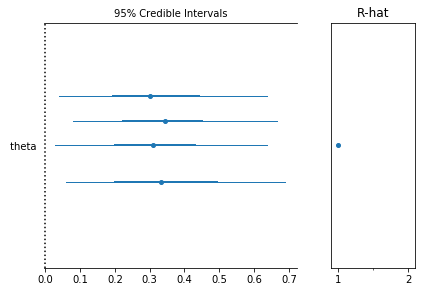

In [16]:
pm.forestplot(multi_chain, varnames=['theta']);

In [17]:
pm.summary(multi_chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.335532,0.166743,0.004791,0.039034,0.65109,1051.008692,1.001863


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0740bdfda0>,
      dtype=object)

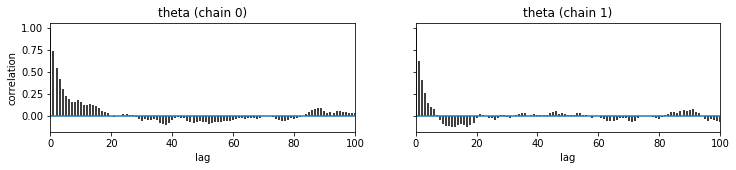

In [20]:
pm.autocorrplot(chain)

In [29]:
pm.effective_n(multi_chain)

{'theta': 1051.0086919827863}

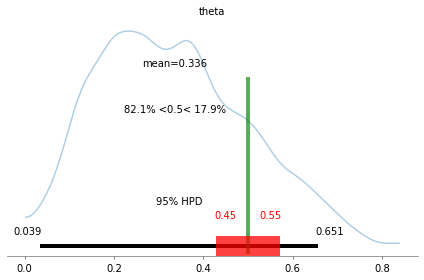

In [27]:
pm.plot_posterior(multi_chain, kde_plot=True, rope=[.45,.55], ref_val=0.5)

### What should we look for
1. KDE plot should look like smooth curve. Often but not always, as the number of samples grow, distribution of each parameter should look like gaussian.
2. Plot in the right should look like white noise.
3. We should not see any recognizable pattern, we should not see a curve going up or down, instead we want a curve meandering around a single value.

### Multiple parallel chains
We can run multiple parallel chains in pymc. These parallel chains, since they are independent of each other, each should be good sample. All chains should look similar to each other. 

### Gelman-Rubin Test
Idea of this test is to compare variance between chains with the variance within chains. Ideally we should expect $\hat R =1 $. As empirical rule, we will be good with value less than 1.1.
We can also visualize $\hat R$ with forestplot together with mea, 50% HPD and 95% HPD for each parameter distribution.

### MC Error 
MC error is estimation of the error introduced by the sampling method. The estimation takes account that samples are not truly independent.  
$$ MC_{error} = \frac{\sigma(x)}{\sqrt n} $$
This error should be below the precision we want in our result. Since the nature of algorithm is stochcastic, we will get different values for mc error on each run, but the values will be similar. If the values are not similar we should try increasing samples.

### Autocorrelation
Ideal sample will lack autocorrelation, i.e. value at one point should be independent of values at other points. In practice samples generated from MCMC can be autocorrelated. 
We seek samples that quicly drops to low values of autocorrelation. The more autcorrelated a parameter is, larger number of samples we will need to obtain a given precision.

### Effective Size

### Some ways to reduce autocorrelation
1. More effective sampling 
2. Transform data and reparametrize the model
3. Thin a chain (Slicing the samples in python)
4. Increase the sample size